In [3]:
import numpy as np
import pandas as pd
import sqlite3 as sq
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from sklearn.model_selection import train_test_split


In [3]:
with gzip.open('compensation_cpi.csv.gz', 'rb') as f:
    df2= pd.read_csv(f)
#df2.head()

In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466589 entries, 0 to 1466588
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   year                1466589 non-null  int64  
 1   department          1466587 non-null  object 
 2   job_title           1466043 non-null  object 
 3   base_salary         1465890 non-null  float64
 4   overtime            1433207 non-null  float64
 5   irregular_cash      1466155 non-null  float64
 6   total_cash          1466589 non-null  float64
 7   retirement          1466589 non-null  float64
 8   health              1447602 non-null  float64
 9   other_benefits      830557 non-null   float64
 10  total_benefits      1466589 non-null  float64
 11  total_compensation  1466589 non-null  float64
 12  city_id             1466589 non-null  int64  
 13  annual_average_cpi  1466589 non-null  float64
 14  inflation_rate      1466589 non-null  float64
dtypes: float64(11),

##  Check for duplicates

In [5]:
#Count the number of duplicates
num_duplicates = df2.duplicated().sum()
num_duplicates
# #view duplicate rows
# duplicate_row = df[df.duplicated()]
# duplicate_row.head()

27904

In [6]:
# drop duplicates and reset index
df2 = df2.drop_duplicates().reset_index(drop=True)
df2.shape

(1438685, 15)

## Check for missing data

In [7]:
# Check missing data
df2.isnull().sum()

year                       0
department                 2
job_title                446
base_salary              680
overtime               33113
irregular_cash           406
total_cash                 0
retirement                 0
health                 18833
other_benefits        618294
total_benefits             0
total_compensation         0
city_id                    0
annual_average_cpi         0
inflation_rate             0
dtype: int64

#### --> The null values in compensation columns could be due to the fact that those values are not applicable such as people did not have overtime work, or contractors that might not subject to compensation. It is safe to impute those missing value with 0 

In [8]:
#Impute missing value in salary an dcompensation with 0 value
df2[['overtime', 'irregular_cash' ,  'health', 'other_benefits']] = df2[[ 'overtime', 'irregular_cash' ,  'health', 'other_benefits']].fillna(0)
df2['job_title'] = df2['job_title'].fillna("Not disclosed")
df2['base_salary'] = df2['base_salary'].fillna((df2['total_cash'] - df2['overtime'] - df2['irregular_cash']))


In [9]:
#observe row with null values in department 
dep_null = df2[df2['department'].isnull()]
dep_null.head()

,year,department,job_title,base_salary,overtime,irregular_cash,total_cash,retirement,health,other_benefits,total_benefits,total_compensation,city_id,annual_average_cpi,inflation_rate
138816,2017,NaN,Sheriff's Cadet,49630.50,15016.51,3197.52,67844.53,10619.27,12779.88,4796.56,28195.71,96040.24,2,245.1,2.1
425621,2017,NaN,Police Officer 2,116189.62,40990.09,2260.08,159439.80,20076.66,14515.01,2724.05,37315.72,196755.52,2,245.1,2.1


In [10]:
#fill in the missing police department names
df2['department'].fillna('Police',inplace=True)

In [11]:
df2.isna().sum()
df2.isnull().sum()

year                  0
department            0
job_title             0
base_salary           0
overtime              0
irregular_cash        0
total_cash            0
retirement            0
health                0
other_benefits        0
total_benefits        0
total_compensation    0
city_id               0
annual_average_cpi    0
inflation_rate        0
dtype: int64

In [12]:
#Observe job title
df2['job_title'].nunique()

4175

In [13]:
unique_values2 = df2.groupby('city_id')['job_title'].nunique()
unique_values2

city_id
1     682
2    1360
3    2159
Name: job_title, dtype: int64

In [14]:
# unique_values = df.groupby('department')['job_title'].unique()

# # Print the unique values for each group
# for group, values in unique_values.items():
#     print(f"Group '{group}' has the following unique values in the 'column_name' column:")
#     print(values)
#     print()

#### --> there are almost 5000 job_titles which would be a challenge as a feature in modeling. In addition condensing is not an easy task, so we might have to drop it, therefore imputing missing data is not neccesary here.

## Condensing Department Names

In [15]:
def replace_text(text):
    if pd.isna(text) or text is None:
        return text
    elif target_word.lower() in text.lower():
        return new_word
    else:
        return text

In [16]:
target_word= "Police"
new_word= "Police"
df2['department'] = df2['department'].apply(replace_text)

In [17]:
dept_dict = {
    'Police': 'Police', 'Sheriff': 'Police', "Vcet" : "Police",   
    "Fire" : "Emergency Management",    "Emergency" : "Emergency Management",
    "PW" : "Public Works",    "Public" : "Public Works",    "Water" : "Public Works",    "DOT" : "Public Works",    "Transport" : "Public Works",
    "Plan" : "Public Works",    "Building" : "Public Works",    #"District" : "Public Works",    
    "PRNS" : "Parks",    "Recre" : "Parks",    "Zoo" : "Parks",    "Parks" : "Parks",    "Arena" : "Parks",
    "City" : "City Mgmt",    "Convention" : "City Mgmt",    "Neighbor" : "City Mgmt",    "Election" : "City Mgmt",    "Council" : "City Mgmt",
    "CII" : "City Mgmt",    "Clerk" : "City Mgmt",    "Registrar" : "City Mgmt",    "Housing" : "City Mgmt",    "Mayor" : "City Mgmt",    "rda" : "City Mgmt",
    "Airport" : "Airport",    "Airside" : "Airport",
    "Finance" : "Finance",    "Auditor" : "Finance",    "Assessor" : "Finance",    "Controller" : "Finance",    "Tax" : "Finance", "Treasure" : "Finance",
    "Board" : "Law and Reg",    "Attorney" : "Law and Reg",    "Court" : "Law and Reg",
    "Ethics" : "Law and Reg",    "Probation" : "Law and Reg",    "Regulation" : "Law and Reg",
    "prt" : "Port",    "port" : "Port", "Harbor" : "Port",
    "Human" : "Human Services",    "Retire" : "Human Services",    "Child" : "Human Services",    "Service" : "Human Services",
    "Personnel" : "Human Services",    "Aging" : "Human Services",    "Women" : "Human Services",    "Pension" : "Human Services",
    "Disability" : "Human Services",    "Families" : "Human Services", "Youth" : "Human Services",
    "ESD" : "Human Services",    "Employee" : "Human Services",
    "Info" : "IT",    "Tech" : "IT",
    "Envi" : "Energy, Env, Economy",    "Energy" : "Energy, Env, Economy",    "Power" : "Energy, Env, Economy", "Econ" : "Energy, Env, Economy",
    "Science" : "Libraries, Arts, Science, Museums",    "Librar" : "Libraries, Arts, Science, Museums",    "Museum" : "Libraries, Arts, Science, Museums",
    "Memorial" : "Libraries, Arts, Science, Museums",    "Monument" : "Libraries, Arts, Science, Museums",    "Arts" : "Libraries, Arts, Science, Museums",
    "Cultur" : "Libraries, Arts, Science, Museums", "Art Commission" : "Libraries, Arts, Science, Museums"
}

In [18]:
for key in dept_dict:
    target_word= key
    new_word= dept_dict[key]
    df2['department'] = df2['department'].apply(replace_text)

In [19]:
df2['department'].unique()

array(['Parks', 'City Mgmt', 'Public Works', 'Finance', 'Law and Reg',
       'Port', 'Libraries, Arts, Science, Museums', 'Human Services',
       'Police', 'IT', 'Emergency Management', 'Energy, Env, Economy'],
      dtype=object)

## Summary Statistics and outliers

In [20]:
#Summary sttistics
df2.describe()

,year,base_salary,overtime,irregular_cash,total_cash,retirement,health,other_benefits,total_benefits,total_compensation,city_id,annual_average_cpi,inflation_rate
count,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06,1.438685e+06
mean,2.017060e+03,6.939467e+04,7.340716e+03,4.326823e+03,8.106693e+04,1.691722e+04,1.020891e+04,2.804429e+03,2.993055e+04,1.109975e+05,2.379948e+00,2.477668e+02,1.847782e+00
std,2.539337e+00,4.780912e+04,1.709815e+04,9.314511e+03,5.864736e+04,1.653596e+04,6.967392e+03,3.754897e+03,2.205499e+04,7.793299e+04,5.789799e-01,1.163875e+01,1.158377e+00
min,2.013000e+03,-6.877178e+04,-2.490362e+04,-6.908210e+04,-6.877178e+04,-5.869240e+04,-1.259245e+04,-1.063650e+04,-5.039960e+04,-7.408261e+04,1.000000e+00,2.330000e+02,1.000000e-01
25%,2.015000e+03,2.607120e+04,0.000000e+00,2.470000e+00,2.979432e+04,3.089360e+03,3.326620e+03,0.000000e+00,9.083400e+03,4.074871e+04,2.000000e+00,2.370000e+02,1.300000e+00
50%,2.017000e+03,6.940488e+04,9.560000e+01,1.285220e+03,7.790465e+04,1.450748e+04,1.243878e+04,5.029100e+02,3.114874e+04,1.102013e+05,2.000000e+00,2.451000e+02,1.600000e+00
75%,2.019000e+03,1.019360e+05,6.421260e+03,4.961200e+03,1.175153e+05,2.397671e+04,1.539537e+04,5.365810e+03,4.334440e+04,1.621956e+05,3.000000e+00,2.557000e+02,2.100000e+00
max,2.021000e+03,6.519367e+05,4.343939e+05,2.394972e+06,2.394972e+06,2.136775e+05,2.556148e+05,3.569104e+04,2.556148e+05,2.394972e+06,3.000000e+00,2.710000e+02,4.700000e+00


In [21]:
#Check rows with negative values
cols = ['base_salary', 'overtime', 'irregular_cash', 'total_cash',  'retirement', 'health',	'other_benefits', 'total_benefits',	'total_compensation', 'city_id']
negative_rows = df2[cols][(df2[cols] < 0).any(axis=1)]
negative_rows.head()

,base_salary,overtime,irregular_cash,total_cash,retirement,health,other_benefits,total_benefits,total_compensation,city_id
2985,144646.56,0.00,12521.65,157168.20,41550.49,17936.85,-239.02,59248.32,216416.53,2
4620,21792.19,-292.80,94.68,21594.07,0.00,0.00,1676.05,1676.05,23270.12,2
8231,119694.97,0.00,11084.23,130779.20,27239.17,15551.14,-189.99,42600.32,173379.52,2
9500,37013.00,193.93,-599.05,36607.88,10978.06,289.90,0.00,11267.96,47875.84,3
9788,163147.23,31827.60,-2665.12,192309.72,76434.48,18511.00,0.00,94945.48,287255.20,3


In [22]:
negative_rows.shape

(5882, 10)

#### --> there are negative values distributed randomly in most of the float type columns such as base_salary, overtime, etc. It doesn't seem to make sense why would someone working would get negative cash and negative benefit pay. There are roughly 6000 instances which is very small portion of the entire data, so we decided to drop these rows

In [23]:
#Drop those row with negative values
df2 = df2.drop(negative_rows.index).reset_index(drop=True)
df2.shape

(1432803, 15)

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


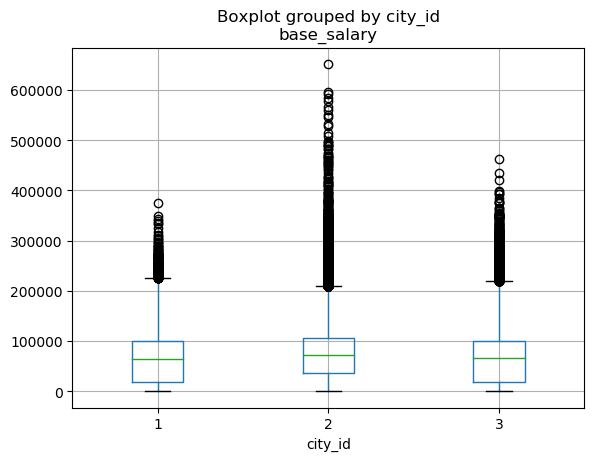

In [24]:
boxplot = df2.boxplot(column=['base_salary'], by='city_id')
plt.show()

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


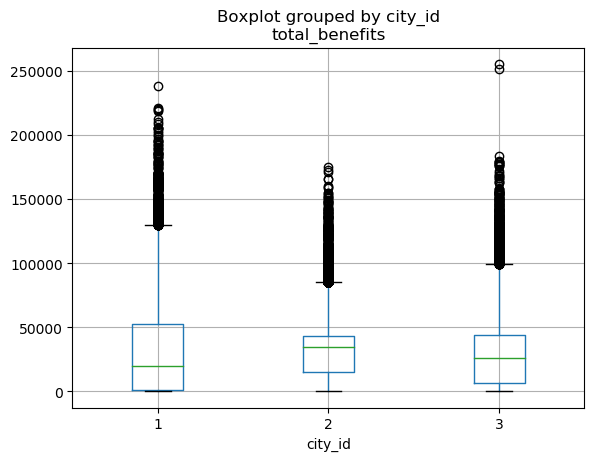

In [25]:
boxplot = df2.boxplot(column=['total_benefits'], by='city_id')
plt.show()

In [26]:
# # create boxplots side by side
# fig, ax = plt.subplots(ncols=2)

# # plot data in the first subplot
# ax[0].boxplot(df[['base_salary']])
# ax[0].set_title('Base Salary')

# # plot data in the second subplot
# ax[1].boxplot(df[['base_salary']], by='city_id')
# ax[1].set_title('Base Salary by City')

# # set plot properties
# ax[0].set_xlabel('All cities')
# ax[1].set_xlabel('City ID')
# ax[0].set_ylabel('Base Salary')
# ax[1].set_ylabel('Base Salary')
# plt.suptitle('Boxplots of Base Salary')

# # show plot
# plt.show()


##  Examine Correlation and Feature Selection

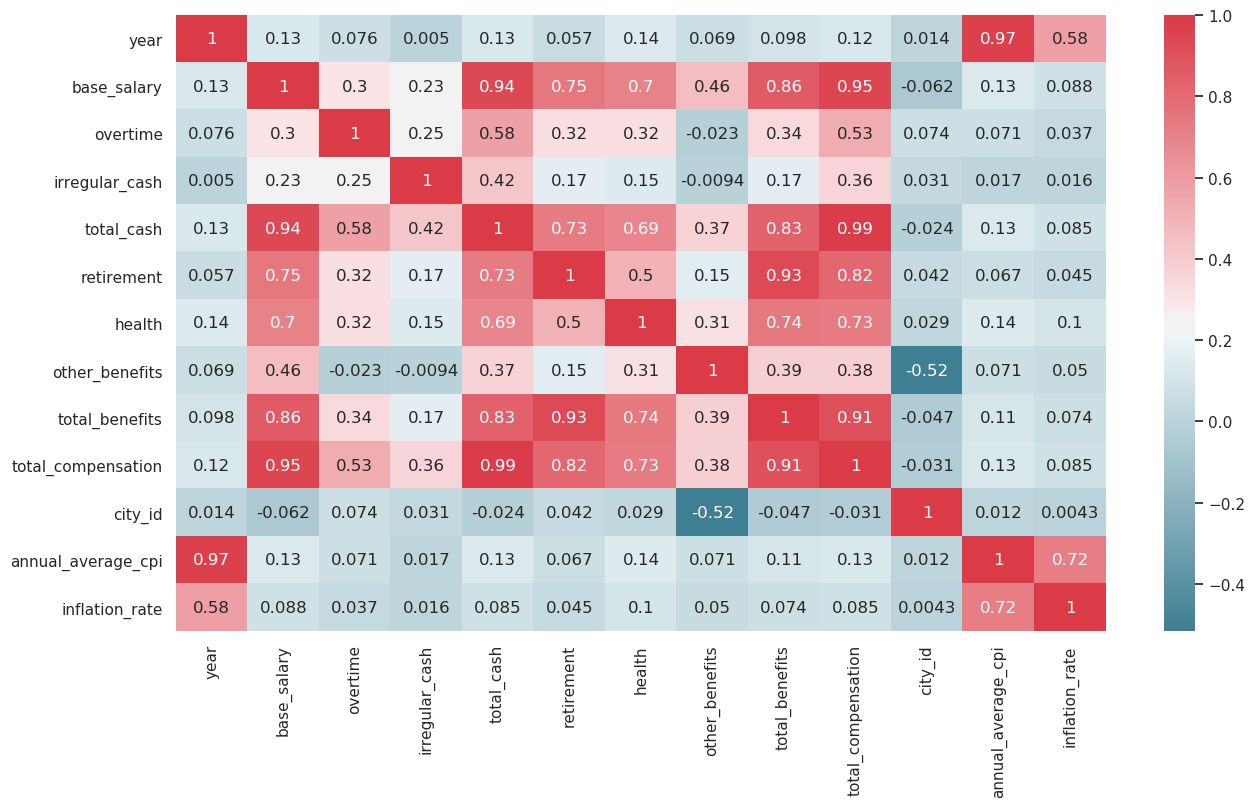

In [27]:
# plot the heatmap and annotation on it
#Correlation matrix 
corr_matrix = df2.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr_matrix, cmap=cmap, annot=True)
plt.show()

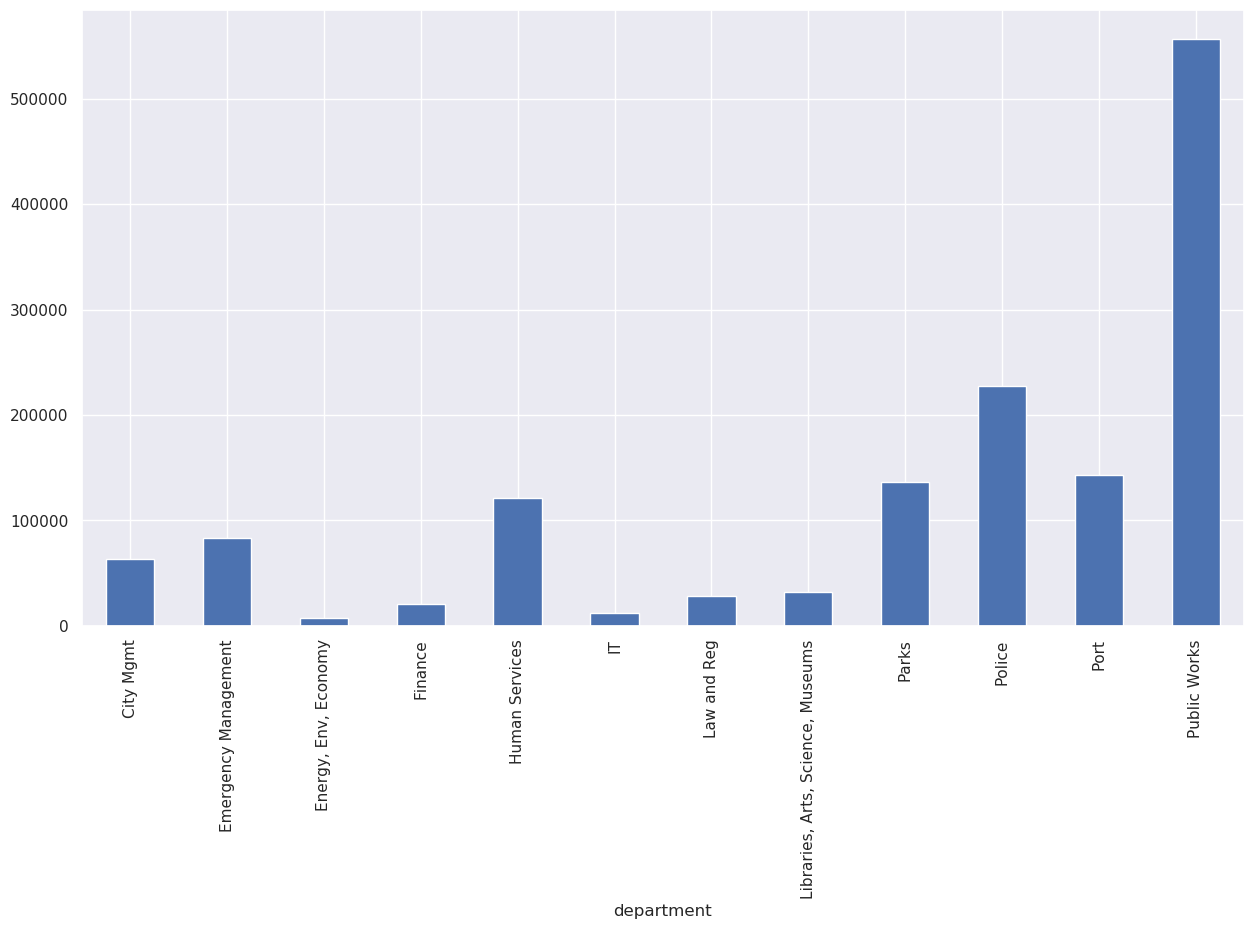

In [28]:
# group by 'category' and count the values in each group
counts = df2.groupby('department')['department'].count()

# plot the counts as a bar chart
counts.plot(kind='bar')
plt.show()

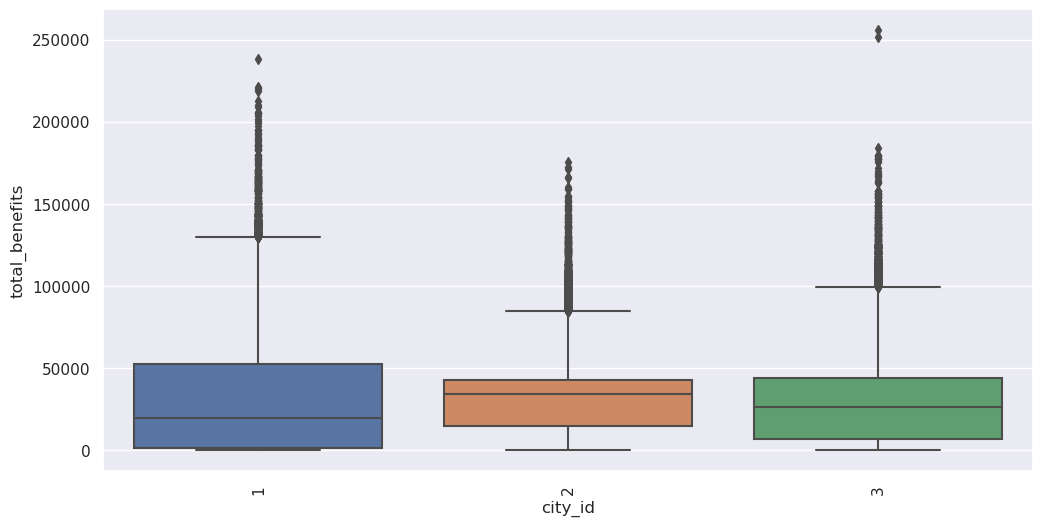

In [29]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df2,x='city_id',y='total_benefits')
plt.xticks(rotation=90)
plt.show()

In [30]:
# #Create Plot and correlation matrix for selected feature
# def corrdot(*args, **kwargs):
#     df = round (args[0].corr(args[1], 'pearson'), 2)
#     corr_text = f"{df:2.2f}".replace("0.", ".")
#     ax = plt.gca()
#     ax.set_axis_off()
#     marker_size = 10000
#     ax.scatter([.5], [.5], marker_size, [df], alpha=0.6, cmap="coolwarm",
#                vmin=-1, vmax=1, transform=ax.transAxes)
#     font_size = 50
#     ax.annotate( df, [.5, .5,],  xycoords="axes fraction",
#                 ha='center', va='center', fontsize=font_size)

# sns.set(style='white', font_scale=2.0)
# g = sns.PairGrid( df, aspect=1.4, diag_sharey=False)
# g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
# g.map_diag(sns.distplot, kde_kws={'color': 'black'})
# g.map_upper(corrdot)
# plt.show()

In [31]:
# # Create a pair grid using seaborn
# g = sns.PairGrid(df)

# # Define the upper and lower plots
# g.map_upper(sns.scatterplot)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.histplot)

# # Display the plot
# plt.show()

In [32]:
#Examine columns with high correlation 
cor_matrix = df2.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),
                                     k=1).astype(bool))

high_corr = [column for column in upper_tri.columns if 
           any(upper_tri[column] > 0.75)]
print('These are the columns prescribed to be potentially dropped: %s'%high_corr)

These are the columns prescribed to be potentially dropped: ['total_cash', 'retirement', 'total_benefits', 'total_compensation', 'annual_average_cpi']


#### --> since total_benefits would be our target, so it would be kept. Annual_average_cpi is highly correlated with year, but Annual_average_cpi might be a better feature to reflect the anual economy which could affect the salary and benefit. 

In [37]:
# #Drop columns
# to_drop = ['year', 'job_title',  'total_cash',  'retirement',   'total_compensation']
# df3 = df2.drop(to_drop, axis=1)
# df3.head()

In [38]:
#df3.to_csv('df_drop_hicorr.csv.gz', index=False, compression='gzip')

### --> *New data frame df_drop_hicorr.csv.gz*

In [39]:
# #Drop more columns 
# to_drop = ['health', 'other_benefits', 'inflation_rate']
# df3 = df3.drop(to_drop, axis=1)
# df3.head()

In [40]:
#df3.to_csv('df_drop_hicorr2.csv.gz', index=False, compression='gzip')

### --> *New data frame df_drop_hicorr2.csv.gz*

In [41]:
#Drop columns
to_drop = ['job_title',  'total_cash',  'retirement',  'health', 'other_benefits', 'inflation_rate',  'total_compensation']
df3 = df2.drop(to_drop, axis=1)
df3.head()

,year,department,base_salary,overtime,irregular_cash,total_benefits,city_id,annual_average_cpi
0,2020,Parks,5257.50,0.00,139.32,418.88,2,258.8
1,2020,City Mgmt,7699.19,1916.90,0.00,746.36,2,258.8
2,2020,City Mgmt,2619.15,930.50,0.00,275.51,2,258.8
3,2020,City Mgmt,1870.62,591.22,0.00,191.07,2,258.8
4,2020,Public Works,158812.14,0.00,5676.94,60283.48,2,258.8


In [42]:
#df3.to_csv('df_final.csv.gz', index=False, compression='gzip')

### --> *New data frame df_final.csv.gz*

In [4]:
with gzip.open('df_final.csv.gz', 'rb') as f:
    df4= pd.read_csv(f)
df4.head()

,year,department,base_salary,overtime,irregular_cash,total_benefits,city_id,annual_average_cpi
0,2020,Parks,5257.50,0.00,139.32,418.88,2,258.8
1,2020,City Mgmt,7699.19,1916.90,0.00,746.36,2,258.8
2,2020,City Mgmt,2619.15,930.50,0.00,275.51,2,258.8
3,2020,City Mgmt,1870.62,591.22,0.00,191.07,2,258.8
4,2020,Public Works,158812.14,0.00,5676.94,60283.48,2,258.8


## Feature engineering

In [5]:
#convert ctity_id , year to string
df4['city_id'] = df4['city_id'].astype(str)
df4['year'] = df4['year'].astype(str)
# Convert categorical data to dummy values
df4= pd.get_dummies(df4, drop_first=True) # drop first dummy column to avoid dummy variable trap
df4.head()

,base_salary,overtime,irregular_cash,total_benefits,annual_average_cpi,year_2014,year_2015,year_2016,year_2017,year_2018,...,department_Human Services,department_IT,department_Law and Reg,"department_Libraries, Arts, Science, Museums",department_Parks,department_Police,department_Port,department_Public Works,city_id_2,city_id_3
0,5257.50,0.00,139.32,418.88,258.8,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,7699.19,1916.90,0.00,746.36,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2619.15,930.50,0.00,275.51,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1870.62,591.22,0.00,191.07,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,158812.14,0.00,5676.94,60283.48,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [6]:
#Adjusting all numbers to present-day CPI which is 2021
max_cpi = df4['annual_average_cpi'].max()

for column in ['base_salary', 'overtime', 'irregular_cash',  'total_benefits']:
    df4[column] = df4[column] * (max_cpi / df4['annual_average_cpi'])
df4.head()

,base_salary,overtime,irregular_cash,total_benefits,annual_average_cpi,year_2014,year_2015,year_2016,year_2017,year_2018,...,department_Human Services,department_IT,department_Law and Reg,"department_Libraries, Arts, Science, Museums",department_Parks,department_Police,department_Port,department_Public Works,city_id_2,city_id_3
0,5505.341963,0.000000,145.887635,438.626275,258.8,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,8062.134815,2007.263910,0.000000,781.543895,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2742.618431,974.364374,0.000000,288.497720,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1958.802241,619.090495,0.000000,200.077164,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,166298.647372,0.000000,5944.554637,63125.282380,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


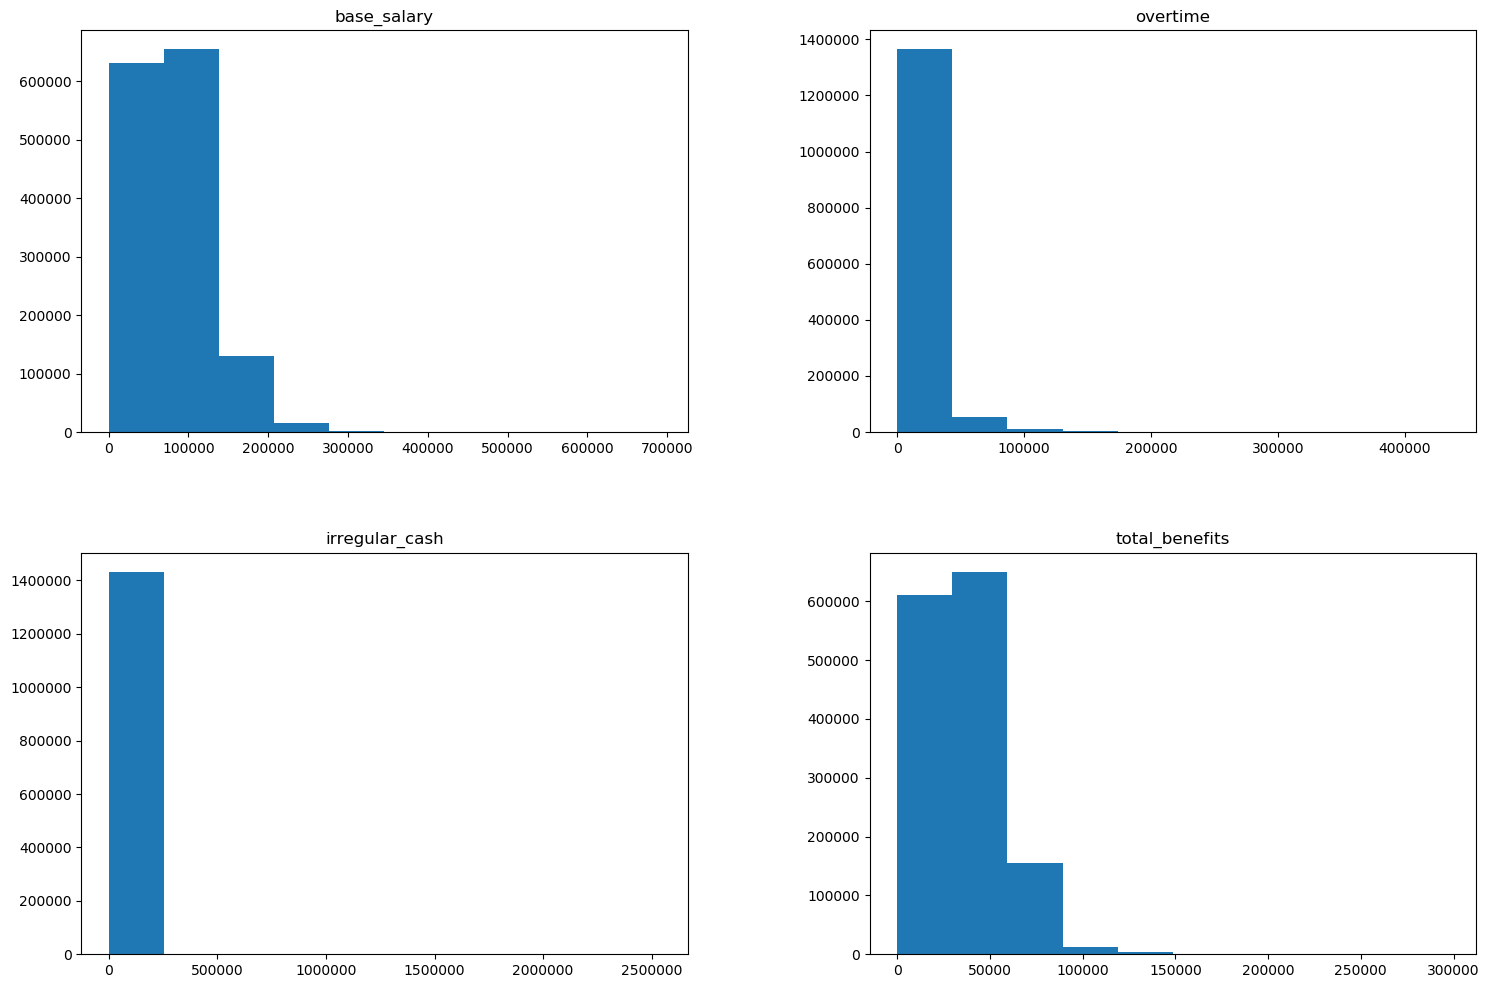

In [6]:
# histograms
df4[[ 'base_salary' , 'overtime',	'irregular_cash', 'total_benefits']].hist(grid=False, figsize=(18, 12))
plt.show()

In [6]:
#set predictor and target dataframes
y = df4[['total_benefits']]
X= df4.drop(['total_benefits'], axis=1)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler

# Split all data into 75% train and 25% holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=508)

# Convert target dataframe  to arrays
y_train2 = np.array(y_train)
y_test2 = np.array(y_test)

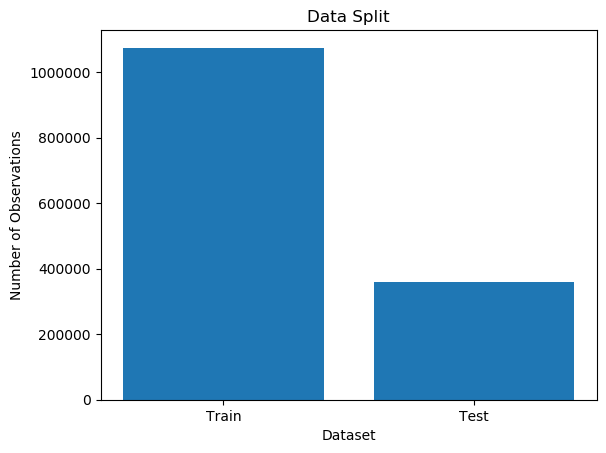

<Figure size 800x600 with 0 Axes>

In [9]:
#show train, validation and test set chart
labels = ["Train",  "Test"]
sizes = [len(X_train.index),  len(X_test.index)]

plt.bar(labels, sizes)
plt.title("Data Split")
plt.xlabel("Dataset")
plt.ylabel("Number of Observations")
plt.figure(figsize=(8, 6))
plt.show()

In [17]:
# # Select the two columns you want to transform
# cols_to_transform = [ 'base_salary' , 'overtime', 'irregular_cash']

# # Initialize PowerTransformer and fit on the selected columns
# X_train_fit =PowerTransformer().fit(X_train[cols_to_transform ])
# # Transform the selected columns for both training and testing set

# X_train[cols_to_transform] = X_train_fit.transform(X_train[cols_to_transform])
# X_test[cols_to_transform] = X_train_fit.transform(X_test[cols_to_transform])

# y_train_log = np.log1p(np.array(y_train2))
# #y_test_log = np.log1p(np.array(y_test2))

#pd.DataFrame(y_train_log).hist(grid=False, figsize=(18, 12))
#plt.show()

In [8]:
# Select the two columns you want to transform
cols_to_transform = [ 'base_salary' , 'overtime', 'irregular_cash']

# Initialize PowerTransformer and fit on the selected columns
X_train_fit = RobustScaler().fit(X_train[cols_to_transform ])
# Transform the selected columns for both training and testing set

X_train[cols_to_transform] = X_train_fit.transform(X_train[cols_to_transform])
X_test[cols_to_transform] = X_train_fit.transform(X_test[cols_to_transform])


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [10]:

# #scaling the data
# #scaling the data
# X_train_fit = RobustScaler().fit(X_train)
# X_train_scaled = X_train_fit.transform(X_train)
# X_test_scaled = X_train_fit.transform(X_test)
                                      
# X_train2= pd.DataFrame(X_train_scaled, columns=X_train.columns)
# X_test2= pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [12]:
X_train.head()

,base_salary,overtime,irregular_cash,annual_average_cpi,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,...,department_Human Services,department_IT,department_Law and Reg,"department_Libraries, Arts, Science, Museums",department_Parks,department_Police,department_Port,department_Public Works,city_id_2,city_id_3
1241779,-0.635434,-0.015092,0.007521,251.1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1396548,0.665480,-0.015092,-0.135505,236.7,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
647017,0.317651,1.297260,0.920171,258.8,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
462797,-0.539971,-0.015092,-0.262128,240.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
966941,0.698426,4.337990,2.425067,240.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [13]:
X_train.shape

(1074602, 25)

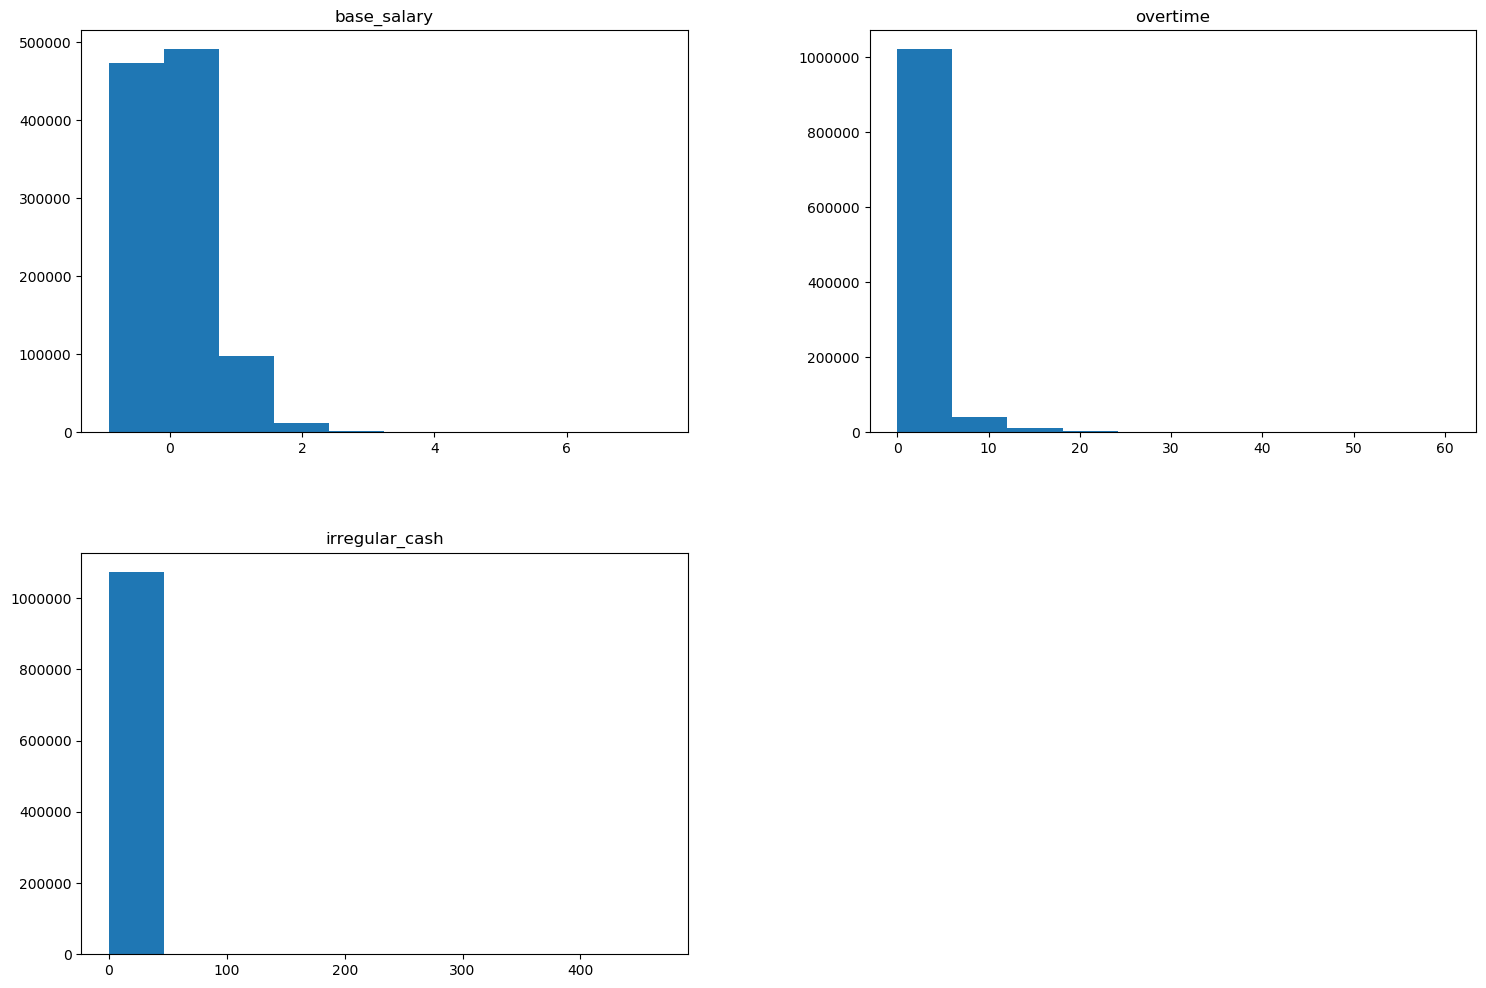

In [13]:
# histograms
X_train[[ 'base_salary' , 'overtime',	'irregular_cash']].hist(grid=False, figsize=(18, 12))
plt.show()

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression,  Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
import random

### Multiple Linear Regression

In [15]:
lr = LinearRegression().fit(X_train, y_train2)

In [16]:
# Print the parameters (coefficients) of the model
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

Coefficients: [[ 3.11449401e+04  5.82492406e+02 -8.28762225e+02 -1.67377864e+01
   1.30217005e+03  1.05100506e+03 -2.07554781e+02 -1.37142182e+03
  -1.21041755e+03 -1.03996015e+03  9.62522728e+01  1.36949065e+03
   9.08335527e+03  1.33798498e+03  1.58862289e+03  2.34578762e+03
   7.78327829e+02  2.83590313e+03 -9.51828296e+02 -1.51662261e+03
   9.73754427e+03  4.25806004e+03 -2.55623778e+02 -4.27521374e+03
  -3.68375816e+03]]
Intercept: [38194.70557889]


In [17]:
# make predictions on the test data
y_pred = lr.predict(X_test)
#y_pred = np.expm1(y_pred_log)
# calculate the RMSE between the predicted and true values
rmse = np.sqrt(mean_squared_error(y_test2, y_pred))

# print the RMSE
print("RMSE:", rmse)

RMSE: 11250.913003130454


In [18]:
mae = mean_absolute_error(y_test, y_pred)
mae

7862.106100343796

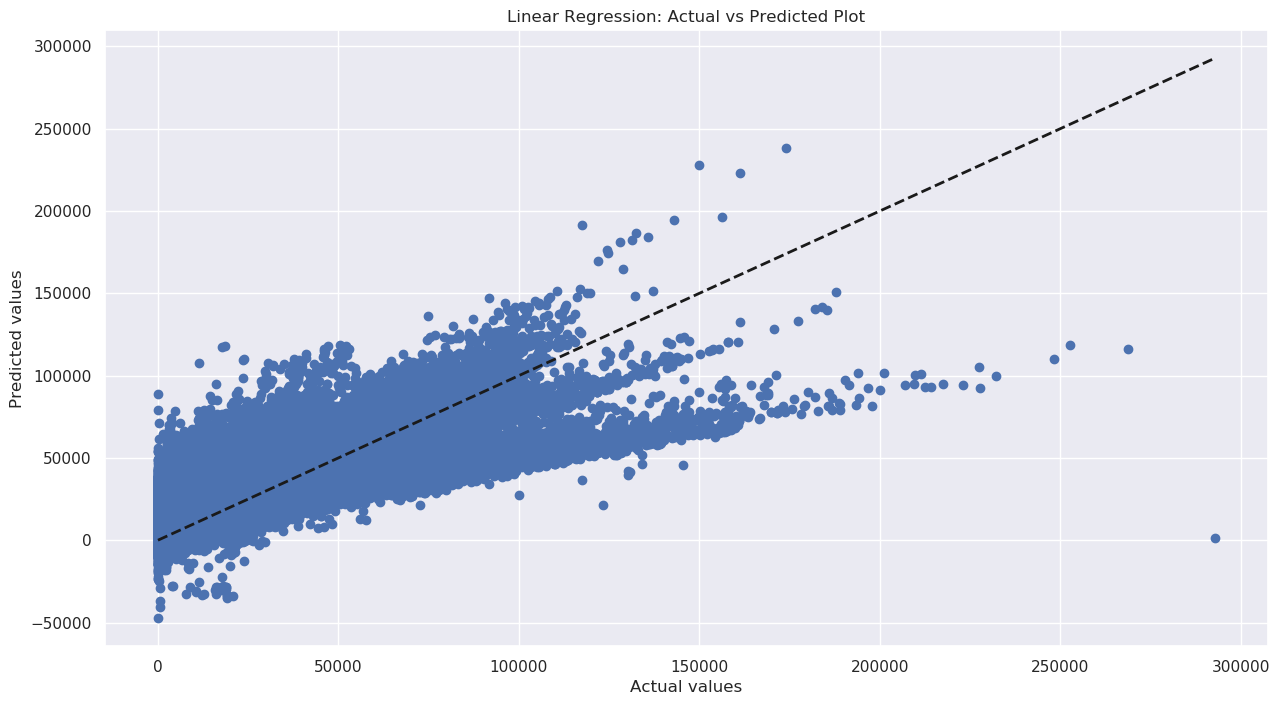

In [67]:
plt.scatter(y_test2, y_pred)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Linear Regression: Actual vs Predicted Plot')
plt.show()

### Ridge Regression

In [22]:
# Fit a Ridge regression model
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train2)

y_pred = ridge.predict(X_test)
# calculate the RMSE between the predicted and true values
rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
rmse 

11250.913017473384

In [69]:
mae = mean_absolute_error(y_test2, y_pred)
mae

7862.106286887241

In [10]:
random.seed(508)

alphas = [0.01, 0.1, 0.2, 0.5, 1, 10, 100]

# define a custom RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Set up a grid search to find the best alpha value
param_grid = {'alpha': alphas}
#ridge = Ridge(normalize=True)
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring=rmse_scorer)
grid_search.fit(X_train, y_train2)

# Print the best alpha value and the corresponding mean squared error
print("Best alpha value:", grid_search.best_params_['alpha'])
print("Best RMSE:", -grid_search.best_score_)

# Fit the Ridge regression model with the best alpha value
best_ridge = Ridge(alpha=grid_search.best_params_['alpha'])
best_ridge.fit(X_train, y_train2)

# Make predictions on the testing set
y_pred = best_ridge.predict(X_test)

Best alpha value: 10
Best RMSE: 11264.304311777008


In [11]:
# Compute the mean squared error
mae = mean_absolute_error(y_test2, y_pred)
mae

7862.124861247763

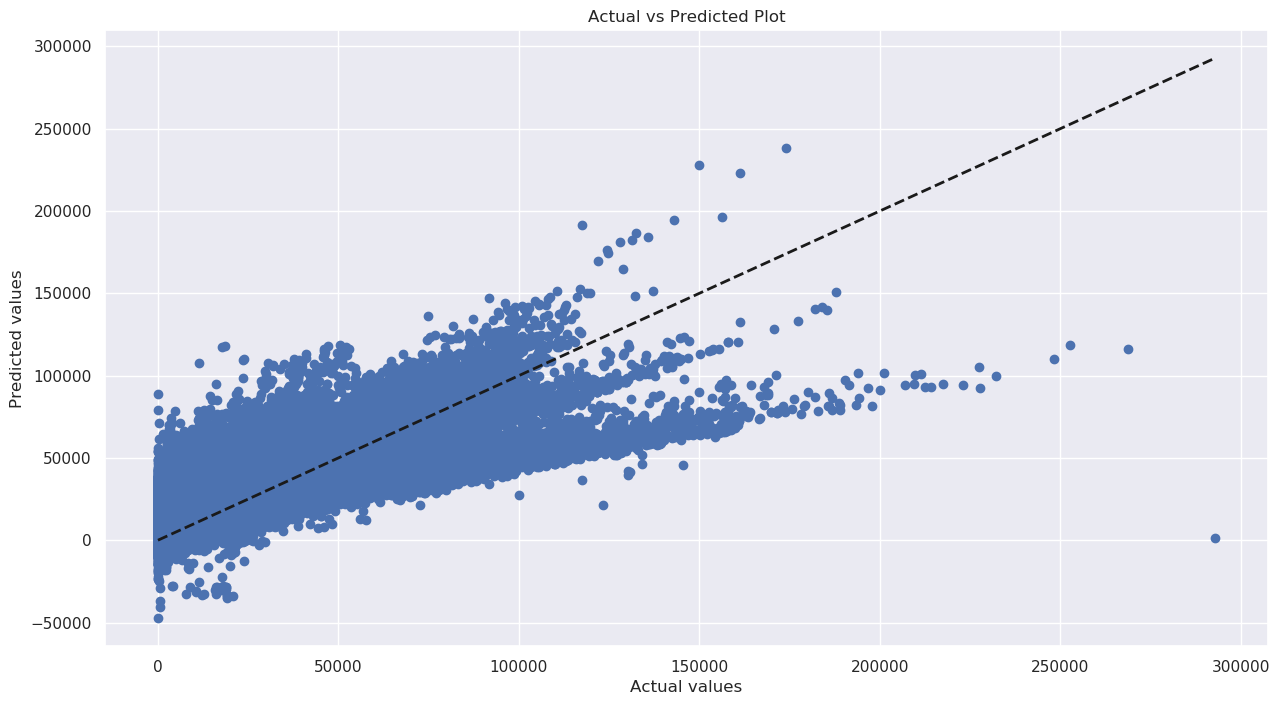

In [73]:
plt.scatter(y_test2, y_pred)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Ridge: Actual vs Predicted Plot')
plt.show()

### Lasso Regression

In [28]:
random.seed(508)

alphas = [0.01, 0.1, 0.2, 0.5, 1, 10, 100]

# # define a custom RMSE scoring function
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))
# rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Set up a grid search to find the best alpha value
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(Lasso(), param_grid, cv=5, scoring=rmse_scorer)
grid_search.fit(X_train, y_train2)

# Print the best alpha value and the corresponding mean squared error
print("Best alpha value:", grid_search.best_params_['alpha'])
print("Best RMSE:", -grid_search.best_score_)

# Fit the Ridge regression model with the best alpha value
best_lasso = Lasso(alpha=grid_search.best_params_['alpha'])
best_lasso.fit(X_train, y_train2)

# Make predictions on the testing set
y_pred = best_lasso.predict(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39364643142111.06, tolerance: 49283905589.008575
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39221501390212.49, tolerance: 49219037218.30421
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39097787379765.19, tolerance: 49197361231.89231
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39208268354

Best alpha value: 0.01
Best RMSE: 11264.304616843205


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49040123941737.766, tolerance: 61544958129.508705
  positive)


### Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=508)
# Fit the model to the training data
rf.fit(X_train, y_train2.ravel())

# Use the model to make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the performance of the model using mean squared error and r-squared
mse = mean_squared_error(y_test2, y_pred)

print("Mean Squared Error: ", mse)


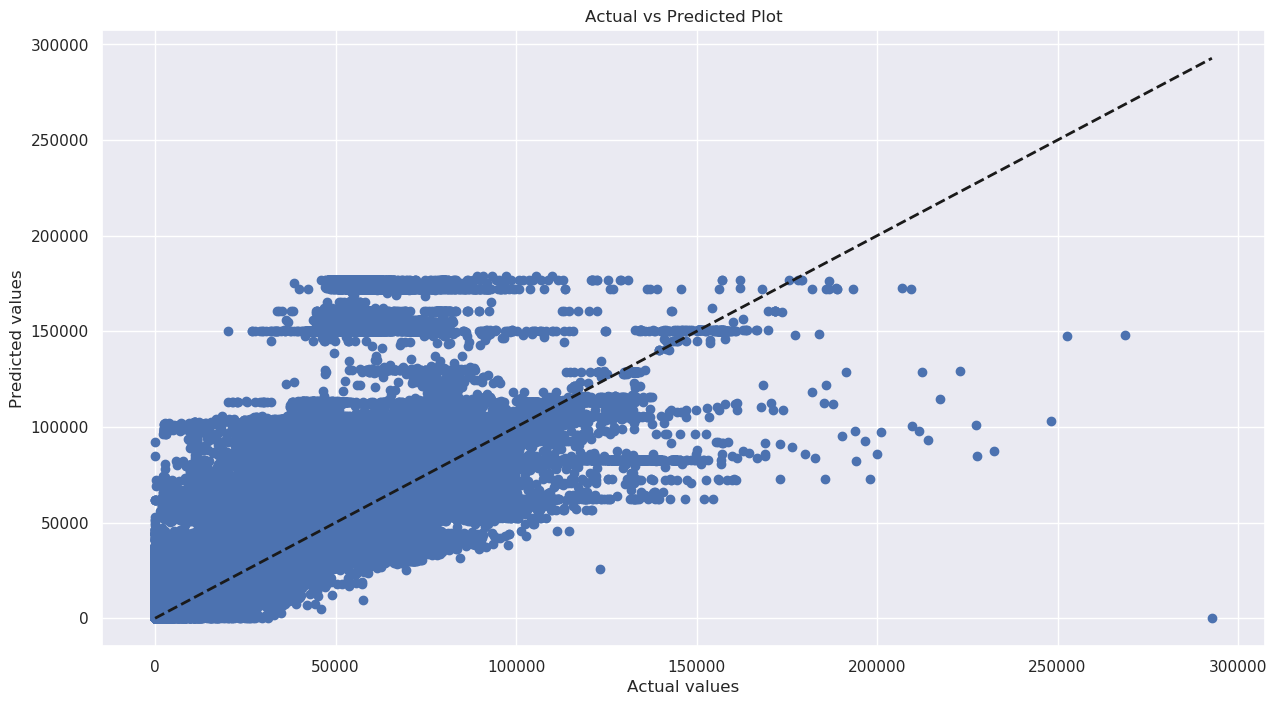

In [87]:
plt.scatter(y_test2, y_pred)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted Plot')
plt.show()

In [85]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt


title = "Learning Curve (Random Forest Regressor)"
cv = 5 # number of cross-validation folds
plot_learning_curve(rf, title, X_train2, y_train2.ravel(), cv=cv)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

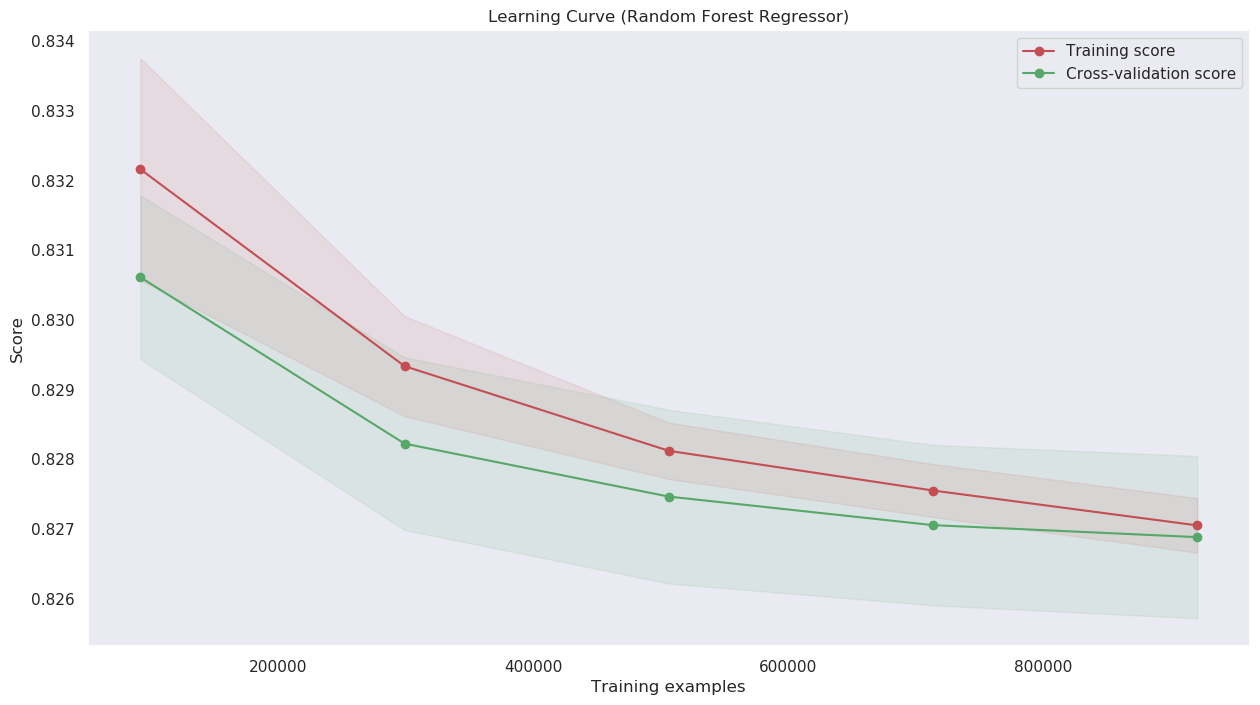

In [86]:
plt.show()

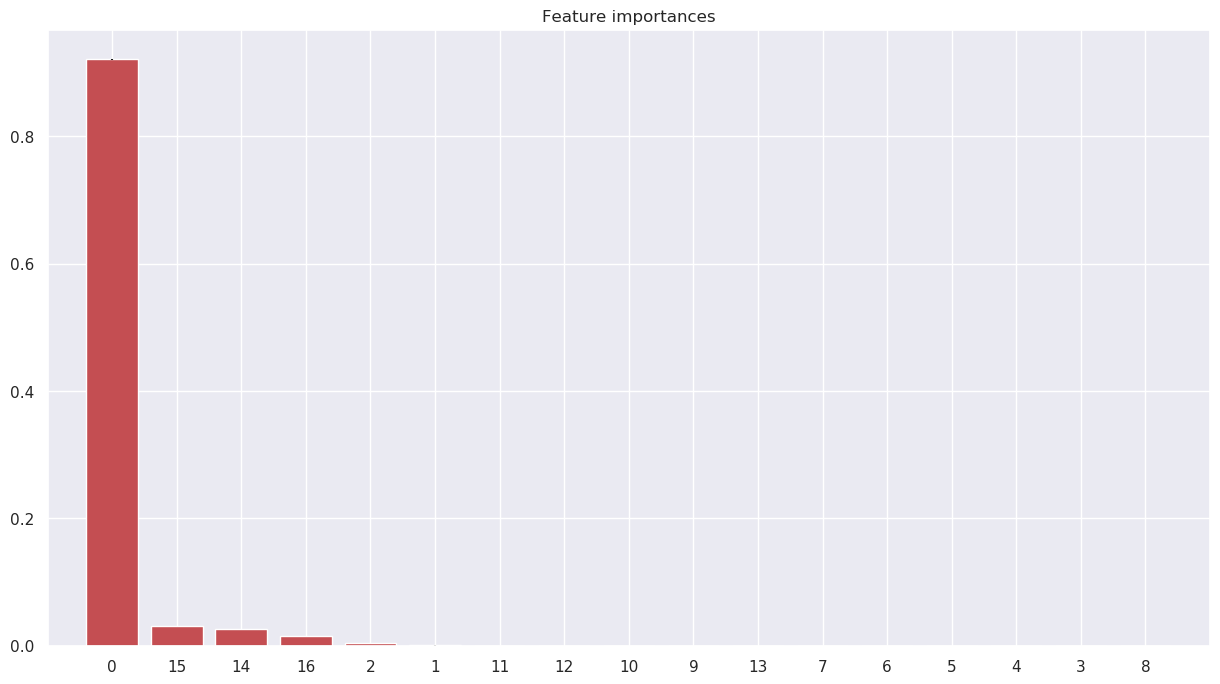

In [87]:
#Feature importance
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# # train a Random Forest Regressor model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train, y_train)

# plot feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

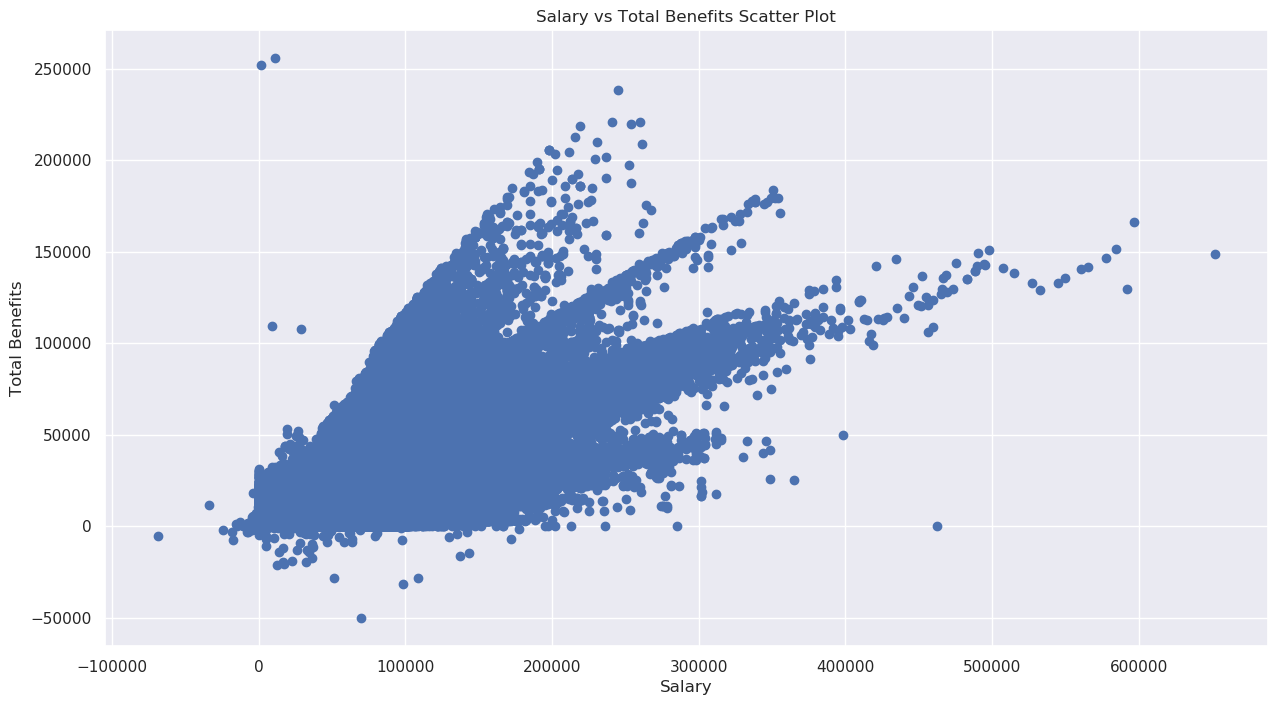

In [112]:
# Create the scatter plot
plt.scatter(df4['base_salary'], df4['total_benefits'])
plt.xlabel('Salary')
plt.ylabel('Total Benefits')
plt.title('Salary vs Total Benefits Scatter Plot')
plt.show()

In [100]:
lr2= LinearRegression().fit(np.array(X_train['base_salary']).reshape(-1, 1), y_train2)

In [101]:
# make predictions on the test data
y_pred = lr2.predict(np.array(X_test['base_salary']).reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test2, y_pred))

In [103]:
# calculate the RMSE between the predicted and true values
#rmse = np.sqrt(mean_squared_error(y_val2, y_pred))
mae = mean_absolute_error(y_test2, y_pred)
mae

7899.037006717493

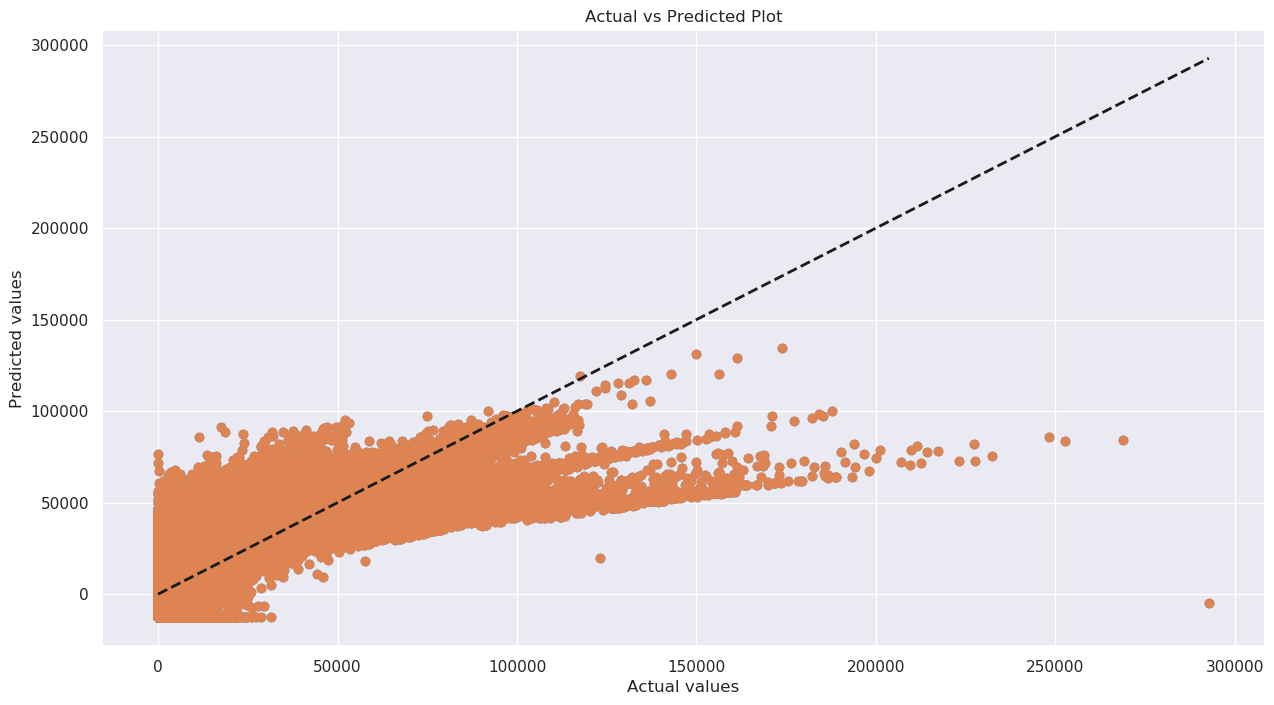

In [105]:
plt.scatter(y_test2, y_pred)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted Plot')
plt.show()

In [ ]:
# s3_client = boto3.client("s3")
# BUCKET='508_team4'
# KEY='modeling/train/train.csv'
# response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

# with io.StringIO() as csv_buffer:
#     train.to_csv(csv_buffer, index=False, header=False)

#     response = s3_client.put_object(
#         Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
#     )

In [2]:
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import boto3
import os

In [ ]:
bucket = sess.default_bucket()
prefix = '<your_s3_prefix>'

# Autopilot

In [36]:
import boto3
import sagemaker
import pandas as pd
import json

In [18]:

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [7]:
auto_df = df4
auto_df.head()

,base_salary,overtime,irregular_cash,total_benefits,annual_average_cpi,year_2014,year_2015,year_2016,year_2017,year_2018,...,department_Human Services,department_IT,department_Law and Reg,"department_Libraries, Arts, Science, Museums",department_Parks,department_Police,department_Port,department_Public Works,city_id_2,city_id_3
0,5505.341963,0.000000,145.887635,438.626275,258.8,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,8062.134815,2007.263910,0.000000,781.543895,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2742.618431,974.364374,0.000000,288.497720,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1958.802241,619.090495,0.000000,200.077164,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,166298.647372,0.000000,5944.554637,63125.282380,258.8,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [9]:
# Split all data into 90% train and 10% holdout
auto_train, auto_test = train_test_split(auto_df, test_size=0.25, random_state=508)

In [11]:
auto_train.shape

(1074602, 26)

#### Write train csv path with header for autopilot

In [12]:
autopilot_train_path = "./compensation_cpi_autopilot.csv"
auto_train.to_csv(autopilot_train_path, index=False, header=True)

#### Upload data to s3 for autopilot

In [13]:
train_s3_prefix = "data"
autopilot_train_s3_uri = sess.upload_data(path=autopilot_train_path, key_prefix=train_s3_prefix)
autopilot_train_s3_uri

's3://sagemaker-us-east-1-924490614652/data/compensation_cpi_autopilot.csv'

In [14]:
!aws s3 ls $autopilot_train_s3_uri

2023-04-10 07:19:49  113300010 compensation_cpi_autopilot.csv


In [15]:
%store autopilot_train_s3_uri

Stored 'autopilot_train_s3_uri' (str)


#### View train data stored in S3 bucket

In [19]:
!aws s3 cp $autopilot_train_s3_uri ./tmp/

download: s3://sagemaker-us-east-1-924490614652/data/compensation_cpi_autopilot.csv to tmp/compensation_cpi_autopilot.csv


In [22]:
import csv

df5 = pd.read_csv("./tmp/compensation_cpi_autopilot.csv")
df5.head()


,base_salary,overtime,irregular_cash,total_benefits,annual_average_cpi,year_2014,year_2015,year_2016,year_2017,year_2018,...,department_Human Services,department_IT,department_Law and Reg,"department_Libraries, Arts, Science, Museums",department_Parks,department_Police,department_Port,department_Public Works,city_id_2,city_id_3
0,23593.275110,0.000000,1462.881959,11261.339705,251.1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,131477.705112,0.000000,686.945501,58580.548416,236.7,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,102632.296947,9207.026043,6414.123918,49454.379521,258.8,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,31509.960417,0.000000,0.000000,10898.784417,240.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,134209.848042,30539.780417,14578.377250,41240.554167,240.0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


#### Setup the S3 Location for the Autopilot-Generated Assets

In [23]:
prefix_model_output = "models/autopilot"

model_output_s3_uri = "s3://{}/{}".format(bucket, prefix_model_output)

print(model_output_s3_uri)

s3://sagemaker-us-east-1-924490614652/models/autopilot


In [24]:
max_candidates = 3

job_config = {
    "CompletionCriteria": {
        "MaxRuntimePerTrainingJobInSeconds": 900,
        "MaxCandidates": max_candidates,
        "MaxAutoMLJobRuntimeInSeconds": 5400,
    },
}

input_data_config = [
    {
        "DataSource": {"S3DataSource": {"S3DataType": "S3Prefix", "S3Uri": "{}".format(autopilot_train_s3_uri)}},
        "TargetAttributeName": "total_benefits",
    }
]

output_data_config = {"S3OutputPath": "{}".format(model_output_s3_uri)}

#### Check For Existing Autopilot Jobs

In [26]:
existing_jobs_response = sm.list_auto_ml_jobs()

In [27]:
num_existing_jobs = 0
running_jobs = 0

if "AutoMLJobSummaries" in existing_jobs_response.keys():
    job_list = existing_jobs_response["AutoMLJobSummaries"]
    num_existing_jobs = len(job_list)
    # print('[INFO] You already created {} Autopilot job(s) in this account.'.format(num_existing_jobs))
    for j in job_list:
        if "AutoMLJobStatus" in j.keys():
            if j["AutoMLJobStatus"] == "InProgress":
                running_jobs = running_jobs + 1
    print("[INFO] You have {} Autopilot job(s) currently running << Should be 0 jobs.".format(running_jobs))
else:
    print("[OK] Please continue.")

[INFO] You have 0 Autopilot job(s) currently running << Should be 0 jobs.


### Launch the SageMaker Autopilot Job

In [28]:
from time import gmtime, strftime, sleep

In [29]:
%store -r auto_ml_job_name

try:
    auto_ml_job_name
except NameError:
    timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
    auto_ml_job_name = "automl-dm-" + timestamp_suffix
    print("Created AutoMLJobName: " + auto_ml_job_name)

no stored variable or alias auto_ml_job_name
Created AutoMLJobName: automl-dm-10-07-32-11


In [30]:
print(auto_ml_job_name)

automl-dm-10-07-32-11


In [31]:
%store auto_ml_job_name

Stored 'auto_ml_job_name' (str)


In [32]:
max_running_jobs = 1

if running_jobs < max_running_jobs:  # Limiting to max. 1 Jobs
    try:
        sm.create_auto_ml_job(
            AutoMLJobName=auto_ml_job_name,
            InputDataConfig=input_data_config,
            OutputDataConfig=output_data_config,
            AutoMLJobConfig=job_config,
            RoleArn=role,
        )
        print("[OK] Autopilot Job {} created.".format(auto_ml_job_name))
        running_jobs = running_jobs + 1
    except:
        print(
            "[INFO] You have already launched an Autopilot job. Please continue see the output of this job.".format(
                running_jobs
            )
        )
else:
    print(
        "[INFO] You have already launched {} Autopilot running job(s). Please continue see the output of the running job.".format(
            running_jobs
        )
    )

[OK] Autopilot Job automl-dm-10-07-32-11 created.


### Analyzing Data and Generate Notebooks

In [33]:
job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

while (
    "AutoMLJobStatus" not in job_description_response.keys()
    and "AutoMLJobSecondaryStatus" not in job_description_response.keys()
):
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job has not yet started. Please wait. ")
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print("[INFO] Waiting for Autopilot Job to start...")
    sleep(15)

print("[OK] AutoMLJob started.")

[OK] AutoMLJob started.


#### Review the SageMaker Processing Jobs

In [34]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/">Processing Jobs</a></b>'.format(
            region
        )
    )
)

In [35]:
%%time

job_status = job_description_response["AutoMLJobStatus"]
job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]

if job_status not in ("Stopped", "Failed"):
    while job_status in ("InProgress") and job_sec_status in ("Starting", "AnalyzingData"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
        print(job_status, job_sec_status)
        sleep(15)
    print("[OK] Data analysis phase completed.\n")

print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress AnalyzingData
InProgress FeatureEngineering
[OK] Data analysis phase completed.



NameError: name 'json' is not defined

In [37]:
print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:924490614652:automl-job/automl-dm-10-07-32-11",
    "AutoMLJobArtifacts": {
        "CandidateDefinitionNotebookLocation": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb",
        "DataExplorationNotebookLocation": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb"
    },
    "AutoMLJobConfig": {
        "CompletionCriteria": {
            "MaxAutoMLJobRuntimeInSeconds": 5400,
            "MaxCandidates": 3,
            "MaxRuntimePerTrainingJobInSeconds": 900
        }
    },
    "AutoMLJobName": "automl-dm-10-07-32-11",
    "AutoMLJobSecondaryStatus": "FeatureEngineering",
    

#### Waiting For Generated Notebooks

In [38]:
job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

while "AutoMLJobArtifacts" not in job_description_response.keys():
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job has not yet generated the artifacts. Please wait. ")
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print("[INFO] Waiting for AutoMLJobArtifacts...")
    sleep(15)

print("[OK] AutoMLJobArtifacts generated.")

[OK] AutoMLJobArtifacts generated.


In [39]:
job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

while "DataExplorationNotebookLocation" not in job_description_response["AutoMLJobArtifacts"].keys():
    job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job has not yet generated the notebooks. Please wait. ")
    print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))
    print("[INFO] Waiting for DataExplorationNotebookLocation...")
    sleep(15)

print("[OK] DataExplorationNotebookLocation found.")

[OK] DataExplorationNotebookLocation found.


In [40]:
generated_resources = job_description_response["AutoMLJobArtifacts"]["DataExplorationNotebookLocation"]
download_path = generated_resources.rsplit("/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb")[0]
job_id = download_path.rsplit("/", 1)[-1]

In [41]:
from IPython.core.display import display, HTML

if not job_id:
    print("No AutoMLJobArtifacts found.")
else:
    display(
        HTML(
            '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/{}/sagemaker-automl-candidates/{}/">S3 Generated Resources</a></b>'.format(
                bucket, prefix_model_output, auto_ml_job_name, job_id
            )
        )
    )


### Download Generated Notebooks & Code

In [42]:
print(download_path)

s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e


In [43]:
try:
    !aws s3 cp --recursive $download_path .
except:
    print('Could not download the generated resources. Make sure the path is correct.')

download: s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/generated_module/MANIFEST.in to generated_module/MANIFEST.in
download: s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/generated_module/README.md to generated_module/README.md
download: s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/generated_module/candidate_data_processors/dpp0.py to generated_module/candidate_data_processors/dpp0.py
download: s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/generated_module/candidate_data_processors/sagemaker_serve.py

In [44]:
!ls ./generated_module/candidate_data_processors

dpp0.py  dpp1.py  dpp2.py  sagemaker_serve.py  trainer.py


In [45]:
!ls ./notebooks

SageMakerAutopilotCandidateDefinitionNotebook.ipynb  sagemaker_automl
SageMakerAutopilotDataExplorationNotebook.ipynb


### Feature Engineering


In [46]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/">Training Jobs</a></b>'.format(
            region
        )
    )
)

In [47]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/transform-jobs/">Batch Transform Jobs</a></b>'.format(
            region
        )
    )
)

In [48]:
%%time

job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job_description_response["AutoMLJobStatus"]
job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
print(job_status)
print(job_sec_status)
if job_status not in ("Stopped", "Failed"):
    while job_status in ("InProgress") and job_sec_status in ("FeatureEngineering"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
        print(job_status, job_sec_status)
        sleep(15)
    print("[OK] Feature engineering phase completed.\n")

print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))

InProgress
FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress FeatureEngineering
InProgress ModelTuning
[OK] Feature engineering phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:924490614652:automl-job/automl-dm-10-07-32-11",
    "AutoMLJobArtifacts": {
        "CandidateDefinitionNotebookLocation": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb",
        "DataExplorationNotebookLocation": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb"
    },
    "AutoMLJobConfig": {
        "CompletionCriteria": {
            "MaxAutoMLJobRuntimeInSecond

### Model Training and Tuning


In [49]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/">Hyperparameter Tuning Jobs</a></b>'.format(
            region
        )
    )
)

In [50]:
%%time
#Tuning  phase
job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job_description_response["AutoMLJobStatus"]
job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
print(job_status)
print(job_sec_status)
if job_status not in ("Stopped", "Failed"):
    while job_status in ("InProgress") and job_sec_status in ("ModelTuning"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        job_sec_status = job_description_response["AutoMLJobSecondaryStatus"]
        print(job_status, job_sec_status)
        sleep(15)
    print("[OK] Model tuning phase completed.\n")

print(json.dumps(job_description_response, indent=4, sort_keys=True, default=str))


InProgress
ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress ModelTuning
InProgress MergingAutoMLTaskReports
[OK] Model tuning phase completed.

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:924490614652:automl-job/automl-dm-10-07-32-11",
    "AutoMLJobArtifacts": {
        "CandidateDefinitionNotebookLocation": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb",
        "DataExplorationNotebookLocation": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb"
    },
    "AutoMLJobConfig": {
        "CompletionCriteria": {


In [51]:
%%time
#Training phase
job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
job_status = job_description_response["AutoMLJobStatus"]
print(job_status)
if job_status not in ("Stopped", "Failed"):
    while job_status not in ("Completed"):
        job_description_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
        job_status = job_description_response["AutoMLJobStatus"]
        print(job_status)
        sleep(10)
    print("[OK] Autopilot Job completed.\n")
else:
    print(job_status)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
[OK] Autopilot Job completed.

CPU times: user 397 ms, sys: 25.6 m

### Viewing All Candidates


In [59]:
candidates_response = sm.list_candidates_for_auto_ml_job(
    AutoMLJobName=auto_ml_job_name, SortBy="FinalObjectiveMetricValue"
)

#### Check that candidates exist

In [60]:
print(candidates_response.keys())

dict_keys(['Candidates', 'ResponseMetadata'])


In [61]:
while "Candidates" not in candidates_response.keys():
    candidates_response = sm.list_candidates_for_auto_ml_job(
        AutoMLJobName=auto_ml_job_name, SortBy="FinalObjectiveMetricValue"
    )
    print("[INFO] Autopilot Job is generating the Candidates. Please wait.")
    print(json.dumps(candidates_response, indent=4, sort_keys=True, default=str))
    sleep(10)

candidates = candidates_response["Candidates"]
print("[OK] Candidates generated.")

[OK] Candidates generated.


In [55]:
print(candidates[0].keys())

dict_keys(['CandidateName', 'FinalAutoMLJobObjectiveMetric', 'ObjectiveStatus', 'CandidateSteps', 'CandidateStatus', 'InferenceContainers', 'CreationTime', 'EndTime', 'LastModifiedTime', 'CandidateProperties'])


In [56]:
while "CandidateName" not in candidates[0]:
    candidates_response = sm.list_candidates_for_auto_ml_job(
        AutoMLJobName=auto_ml_job_name, SortBy="FinalObjectiveMetricValue"
    )
    candidates = candidates_response["Candidates"]
    print("[INFO] Autopilot Job is generating CandidateName. Please wait. ")
    print(json.dumps(candidates, indent=4, sort_keys=True, default=str))
    sleep(10)

print("[OK] CandidateName generated.")

[OK] CandidateName generated.


In [57]:
while "FinalAutoMLJobObjectiveMetric" not in candidates[0]:
    candidates_response = sm.list_candidates_for_auto_ml_job(
        AutoMLJobName=auto_ml_job_name, SortBy="FinalObjectiveMetricValue"
    )
    candidates = candidates_response["Candidates"]
    print("[INFO] Autopilot Job is generating FinalAutoMLJobObjectiveMetric. Please wait. ")
    print(json.dumps(candidates, indent=4, sort_keys=True, default=str))
    sleep(10)

print("[OK] FinalAutoMLJobObjectiveMetric generated.")

[OK] FinalAutoMLJobObjectiveMetric generated.


In [58]:
print(json.dumps(candidates, indent=4, sort_keys=True, default=str))


[
    {
        "CandidateName": "automl-dm-10-07-32-11KWw7cLa0hBd-003-66814648",
        "CandidateProperties": {
            "CandidateMetrics": [
                {
                    "MetricName": "MAE",
                    "Set": "Validation",
                    "StandardMetricName": "MAE",
                    "Value": 6531.89404296875
                },
                {
                    "MetricName": "RMSE",
                    "Set": "Validation",
                    "StandardMetricName": "RMSE",
                    "Value": 9452.228515625
                },
                {
                    "MetricName": "MSE",
                    "Set": "Validation",
                    "StandardMetricName": "MSE",
                    "Value": 89344632.0
                },
                {
                    "MetricName": "R2",
                    "Set": "Validation",
                    "StandardMetricName": "R2",
                    "Value": 0.8436599969863892
                }
  

In [62]:
for index, candidate in enumerate(candidates):
    print(
        str(index)
        + "  "
        + candidate["CandidateName"]
        + "  "
        + str(candidate["FinalAutoMLJobObjectiveMetric"]["Value"])
    )

0  automl-dm-10-07-32-11KWw7cLa0hBd-003-66814648  89344632.0
1  automl-dm-10-07-32-11KWw7cLa0hBd-002-3efd9c25  89344632.0
2  automl-dm-10-07-32-11KWw7cLa0hBd-001-3332516c  70039264.0


### Inspect Trials using Experiments API

In [63]:
from sagemaker.analytics import ExperimentAnalytics, TrainingJobAnalytics

exp = ExperimentAnalytics(
    sagemaker_session=sess,
    experiment_name=auto_ml_job_name + "-aws-auto-ml-job",
)

df = exp.dataframe()
print(df)

                                  TrialComponentName  \
0  automl-dm-10-07-32-11KWw7cLa0hBd-002-3efd9c25-...   
1  automl-dm-10-07-32-11KWw7cLa0hBd-003-66814648-...   
2  automl-dm-10-07-32-11KWw7cLa0hBd-001-3332516c-...   
3  automl-dm-10-07-32-11-dpp1-csv-1-ac6a2ee0cdc54...   
4  automl-dm-10-07-32-11-dpp2-csv-1-da418f26489c4...   
5  automl-dm-10-07-32-11-dpp2-1-3421a8be86b04fe6b...   
6  automl-dm-10-07-32-11-dpp1-1-9be00f19eeb64a97a...   
7  automl-dm-10-07-32-11-db-1-88312a4a0ab24b24885...   

                                         DisplayName  \
0  automl-dm-10-07-32-11KWw7cLa0hBd-002-3efd9c25-...   
1  automl-dm-10-07-32-11KWw7cLa0hBd-003-66814648-...   
2  automl-dm-10-07-32-11KWw7cLa0hBd-001-3332516c-...   
3  automl-dm-10-07-32-11-dpp1-csv-1-ac6a2ee0cdc54...   
4  automl-dm-10-07-32-11-dpp2-csv-1-da418f26489c4...   
5  automl-dm-10-07-32-11-dpp2-1-3421a8be86b04fe6b...   
6  automl-dm-10-07-32-11-dpp1-1-9be00f19eeb64a97a...   
7  automl-dm-10-07-32-11-db-1-88312a4a0ab24b248

### Explore the Best Candidate


In [65]:
best_candidate_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

In [66]:
print(best_candidate_response.keys())

dict_keys(['AutoMLJobName', 'AutoMLJobArn', 'InputDataConfig', 'OutputDataConfig', 'RoleArn', 'AutoMLJobConfig', 'CreationTime', 'EndTime', 'LastModifiedTime', 'BestCandidate', 'AutoMLJobStatus', 'AutoMLJobSecondaryStatus', 'GenerateCandidateDefinitionsOnly', 'AutoMLJobArtifacts', 'ResolvedAttributes', 'ResponseMetadata'])


In [67]:
while "BestCandidate" not in best_candidate_response:
    best_candidate_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    print("[INFO] Autopilot Job is generating BestCandidate. Please wait. ")
    print(json.dumps(best_candidate_response, indent=4, sort_keys=True, default=str))
    sleep(10)

best_candidate = best_candidate_response["BestCandidate"]
print("[OK] BestCandidate generated.")

[OK] BestCandidate generated.


In [68]:
print(json.dumps(best_candidate_response, indent=4, sort_keys=True, default=str))

{
    "AutoMLJobArn": "arn:aws:sagemaker:us-east-1:924490614652:automl-job/automl-dm-10-07-32-11",
    "AutoMLJobArtifacts": {
        "CandidateDefinitionNotebookLocation": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb",
        "DataExplorationNotebookLocation": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/sagemaker-automl-candidates/automl-dm-10-07-32-11-pr-1-5552ac2104684f7498e34be6144a83be2c1e/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb"
    },
    "AutoMLJobConfig": {
        "CompletionCriteria": {
            "MaxAutoMLJobRuntimeInSeconds": 5400,
            "MaxCandidates": 3,
            "MaxRuntimePerTrainingJobInSeconds": 900
        }
    },
    "AutoMLJobName": "automl-dm-10-07-32-11",
    "AutoMLJobSecondaryStatus": "Completed",
    "AutoMLJo

In [69]:
print(best_candidate.keys())

dict_keys(['CandidateName', 'FinalAutoMLJobObjectiveMetric', 'ObjectiveStatus', 'CandidateSteps', 'CandidateStatus', 'InferenceContainers', 'CreationTime', 'EndTime', 'LastModifiedTime', 'CandidateProperties'])


In [70]:
while "CandidateName" not in best_candidate:
    best_candidate_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    best_candidate = best_candidate_response["BestCandidate"]
    print("[INFO] Autopilot Job is generating BestCandidate CandidateName. Please wait. ")
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))
    sleep(10)

print("[OK] BestCandidate CandidateName generated.")


[OK] BestCandidate CandidateName generated.


In [71]:
while "FinalAutoMLJobObjectiveMetric" not in best_candidate:
    best_candidate_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    best_candidate = best_candidate_response["BestCandidate"]
    print("[INFO] Autopilot Job is generating BestCandidate FinalAutoMLJobObjectiveMetric. Please wait. ")
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))
    sleep(10)

print("[OK] BestCandidate FinalAutoMLJobObjectiveMetric generated.")

[OK] BestCandidate FinalAutoMLJobObjectiveMetric generated.


In [72]:
best_candidate_identifier = best_candidate["CandidateName"]
print("Candidate name: " + best_candidate_identifier)
print("Metric name: " + best_candidate["FinalAutoMLJobObjectiveMetric"]["MetricName"])
print("Metric value: " + str(best_candidate["FinalAutoMLJobObjectiveMetric"]["Value"]))

Candidate name: automl-dm-10-07-32-11KWw7cLa0hBd-001-3332516c
Metric name: validation:mse
Metric value: 70039264.0


In [73]:
print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))

{
    "CandidateName": "automl-dm-10-07-32-11KWw7cLa0hBd-001-3332516c",
    "CandidateProperties": {
        "CandidateArtifactLocations": {
            "Explainability": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/documentation/explainability/output",
            "ModelInsights": "s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/documentation/model_monitor/output"
        },
        "CandidateMetrics": [
            {
                "MetricName": "MAE",
                "Set": "Validation",
                "StandardMetricName": "MAE",
                "Value": 5832.0615234375
            },
            {
                "MetricName": "RMSE",
                "Set": "Validation",
                "StandardMetricName": "RMSE",
                "Value": 8368.9462890625
            },
            {
                "MetricName": "MSE",
                "Set": "Validation",
                "StandardMetricName": "MSE",
                

In [75]:
steps = []
for step in best_candidate["CandidateSteps"]:
    print("Candidate Step Type: {}".format(step["CandidateStepType"]))
    print("Candidate Step Name: {}".format(step["CandidateStepName"]))
    steps.append(step["CandidateStepName"])

Candidate Step Type: AWS::SageMaker::ProcessingJob
Candidate Step Name: automl-dm-10-07-32-11-db-1-88312a4a0ab24b24885cd11e84c5b1392bb9
Candidate Step Type: AWS::SageMaker::TrainingJob
Candidate Step Name: automl-dm-10-07-32-11-dpp1-1-9be00f19eeb64a97a58d95421a9ccb529a
Candidate Step Type: AWS::SageMaker::TransformJob
Candidate Step Name: automl-dm-10-07-32-11-dpp1-csv-1-ac6a2ee0cdc54bbfbe42995b7e2c5e
Candidate Step Type: AWS::SageMaker::TrainingJob
Candidate Step Name: automl-dm-10-07-32-11KWw7cLa0hBd-001-3332516c


### See the Containers and Models within the Inference Pipeline

In [88]:
while "InferenceContainers" not in best_candidate:
    best_candidate_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    best_candidate = best_candidate_response["BestCandidate"]
    print("[INFO] Autopilot Job is generating BestCandidate InferenceContainers. Please wait. ")
    print(json.dumps(best_candidate, indent=4, sort_keys=True, default=str))
    sleep(10)

print("[OK] BestCandidate InferenceContainers generated.")

[OK] BestCandidate InferenceContainers generated.


In [89]:
best_candidate_containers = best_candidate["InferenceContainers"]

In [90]:
for container in best_candidate_containers:
    print(container["Image"])
    print(container["ModelDataUrl"])
    print("======================")

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-sklearn-automl:2.5-1-cpu-py3
s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/data-processor-models/automl-dm-10-07-32-11-dpp1-1-9be00f19eeb64a97a58d95421a9ccb529a/output/model.tar.gz
683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1-cpu-py3
s3://sagemaker-us-east-1-924490614652/models/autopilot/automl-dm-10-07-32-11/tuning/automl-dm--dpp1-xgb/automl-dm-10-07-32-11KWw7cLa0hBd-001-3332516c/output/model.tar.gz


In [92]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}